In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os   # zip file from drive and setup,
import shutil
import zipfile

# Source and destination paths
source_zip = "/content/drive/MyDrive/FER465/augmented-data/fer-2013-all.zip"
destination_dir = "/content/FER-2013"

def setup_directory(directory_path):
    """Create directory if it doesn't exist, clear it if it does."""
    # Check if directory exists
    if os.path.exists(directory_path):
        print(f"Directory {directory_path} exists. Clearing contents...")
        # Remove all contents
        for item in os.listdir(directory_path):
            item_path = os.path.join(directory_path, item)
            if os.path.isfile(item_path):
                os.remove(item_path)
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)
        print(f"Directory {directory_path} cleared.")
    else:
        # Create directory and any necessary parent directories
        print(f"Creating directory {directory_path}...")
        os.makedirs(directory_path, exist_ok=True)
        print(f"Directory {directory_path} created.")

def extract_zip(zip_path, extract_to):
    """Extract contents of zip file to specified directory."""
    print(f"Extracting {zip_path} to {extract_to}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Extraction complete.")

if __name__ == "__main__":
    # Make sure parent directories exist
    os.makedirs(os.path.dirname(destination_dir), exist_ok=True)

    # Setup the destination directory
    setup_directory(destination_dir)

    # Extract the ZIP file
    if os.path.exists(source_zip):
        extract_zip(source_zip, destination_dir)
        print(f"Successfully extracted {source_zip} to {destination_dir}")
    else:
        print(f"Error: Source file {source_zip} not found.")

Creating directory /content/FER-2013...
Directory /content/FER-2013 created.
Extracting /content/drive/MyDrive/FER465/augmented-data/fer-2013-all.zip to /content/FER-2013...
Extraction complete.
Successfully extracted /content/drive/MyDrive/FER465/augmented-data/fer-2013-all.zip to /content/FER-2013


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from PIL import Image
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random

In [ ]:

# Set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define constants
DATA_DIR = '/content/FER-2013/all'
MODEL_SAVE_DIR = '/content/drive/MyDrive/FER465/models'
NUM_EPOCHS = 20  # Increased from 10 to 20
BATCH_SIZE = 64  # Increased from 32 to 64
NUM_FOLDS = 5
LEARNING_RATE = 0.0005  # Reduced from 0.001 to 0.0005
WEIGHT_DECAY = 1e-4  # Added weight decay for regularization
NUM_CLASSES = 7  # assuming 7 emotions in FER-2013

# Create model directory if it doesn't exist
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
print(f"Models will be saved to: {MODEL_SAVE_DIR}")

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define enhanced image transformations with more augmentation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize larger than needed
    transforms.RandomCrop(224),     # Random crop to 224x224
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Models will be saved to: /content/drive/MyDrive/FER465/models
Using device: cuda


In [ ]:
# Custom dataset class for FER-2013 with improved handling
class FERDataset(Dataset):
    def __init__(self, data_dir, transform=None, subset=None):
        self.data_dir = data_dir
        self.transform = transform

        # Get emotion classes from train directory
        train_dir = os.path.join(data_dir, 'train')
        self.classes = sorted([d for d in os.listdir(train_dir)
                              if os.path.isdir(os.path.join(train_dir, d))])
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        self.samples = []
        self.targets = []  # Store targets separately for stratified sampling

        # If subset is specified (train or test), only use that folder
        # Otherwise, use both train and test for cross-validation
        subsets = [subset] if subset else ['train', 'test']

        for subset_name in subsets:
            subset_dir = os.path.join(data_dir, subset_name)
            if not os.path.isdir(subset_dir):
                continue

            for class_name in self.classes:
                class_dir = os.path.join(subset_dir, class_name)
                if os.path.isdir(class_dir):
                    for img_name in os.listdir(class_dir):
                        img_path = os.path.join(class_dir, img_name)
                        if os.path.isfile(img_path):  # Make sure it's a file, not a directory
                            label = self.class_to_idx[class_name]
                            self.samples.append((img_path, label))
                            self.targets.append(label)  # Add to targets list

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        # Handle grayscale images and potential errors
        try:
            image = Image.open(img_path)
            if image.mode != 'RGB':
                image = image.convert('RGB')
        except (IOError, OSError) as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image and the label if there's an error
            image = Image.new('RGB', (224, 224), color=0)

        if self.transform:
            image = self.transform(image)

        return image, label

# Create a FocalLoss class for handling class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [ ]:
# Enhanced model creation function with more flexible options
def create_model(pretrained=True, unfreeze_layers=1):
    # Load pre-trained MobileNetV2 model
    if pretrained:
        model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
        print("Using pre-trained MobileNetV2")
    else:
        model = mobilenet_v2(weights=None)
        print("Using MobileNetV2 with random initialization")

    # Freeze layers
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the last few blocks if specified
    if unfreeze_layers > 0:
        # MobileNetV2 has features.18 as the last block
        # Unfreeze last N blocks (starting from 18 and counting backward)
        for i in range(18, max(0, 18 - unfreeze_layers), -1):
            for param in model.features[i].parameters():
                param.requires_grad = True
        print(f"Unfroze the last {unfreeze_layers} blocks of MobileNetV2 features")

    # Replace the final classifier layer
    num_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(0.5),  # Add dropout for regularization
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, NUM_CLASSES)
    )

    # Move model to device
    model = model.to(device)
    return model

# Function to train one epoch with progress tracking
def train_epoch(model, train_loader, criterion, optimizer, epoch, num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    batch_count = len(train_loader)

    start_time = time.time()

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Print progress
        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == batch_count:
            elapsed_time = time.time() - start_time
            print(f"Epoch [{epoch+1}/{num_epochs}] | Batch [{batch_idx+1}/{batch_count}] | "
                  f"Loss: {loss.item():.4f} | Acc: {100.*correct/total:.2f}% | "
                  f"Time: {elapsed_time:.2f}s")

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Enhanced evaluation function
def evaluate(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    class_correct = [0] * NUM_CLASSES
    class_total = [0] * NUM_CLASSES

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Per-class accuracy
            for i in range(len(labels)):
                label = labels[i]
                class_total[label] += 1
                if predicted[i] == label:
                    class_correct[label] += 1

            # Store predictions and labels for metrics
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate class accuracies
    class_accuracies = [class_correct[i] / max(1, class_total[i]) for i in range(NUM_CLASSES)]

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels, class_accuracies

Loading dataset...
Dataset loaded with 46648 samples
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Class distribution:
  angry: 6438 samples (13.80%)
  disgust: 710 samples (1.52%)
  fear: 6657 samples (14.27%)
  happy: 11685 samples (25.05%)
  neutral: 8056 samples (17.27%)
  sad: 7900 samples (16.94%)
  surprise: 5202 samples (11.15%)

Preparing 5-fold cross-validation with stratified sampling...

FOLD 1/5


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training samples: 37318, Validation samples: 9330
Using pre-trained MobileNetV2
Unfroze the last 3 blocks of MobileNetV2 features
Trainable parameters: 1,865,543 (64.70% of total)

Training epoch 1/20...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20] | Batch [10/584] | Loss: 1.3565 | Acc: 18.91% | Time: 7.69s
Epoch [1/20] | Batch [20/584] | Loss: 1.0847 | Acc: 21.56% | Time: 11.75s
Epoch [1/20] | Batch [30/584] | Loss: 1.3900 | Acc: 22.40% | Time: 15.41s
Epoch [1/20] | Batch [40/584] | Loss: 1.3165 | Acc: 23.63% | Time: 17.98s
Epoch [1/20] | Batch [50/584] | Loss: 1.1120 | Acc: 25.62% | Time: 20.67s
Epoch [1/20] | Batch [60/584] | Loss: 1.1608 | Acc: 26.82% | Time: 23.08s
Epoch [1/20] | Batch [70/584] | Loss: 1.1346 | Acc: 28.04% | Time: 26.22s
Epoch [1/20] | Batch [80/584] | Loss: 1.0988 | Acc: 29.04% | Time: 28.15s
Epoch [1/20] | Batch [90/584] | Loss: 1.0213 | Acc: 30.07% | Time: 30.43s
Epoch [1/20] | Batch [100/584] | Loss: 1.0675 | Acc: 30.83% | Time: 32.56s
Epoch [1/20] | Batch [110/584] | Loss: 1.0347 | Acc: 31.22% | Time: 34.64s
Epoch [1/20] | Batch [120/584] | Loss: 1.1167 | Acc: 31.52% | Time: 37.36s
Epoch [1/20] | Batch [130/584] | Loss: 1.0114 | Acc: 31.85% | Time: 40.40s
Epoch [1/20] | Batch [140/584] | Lo

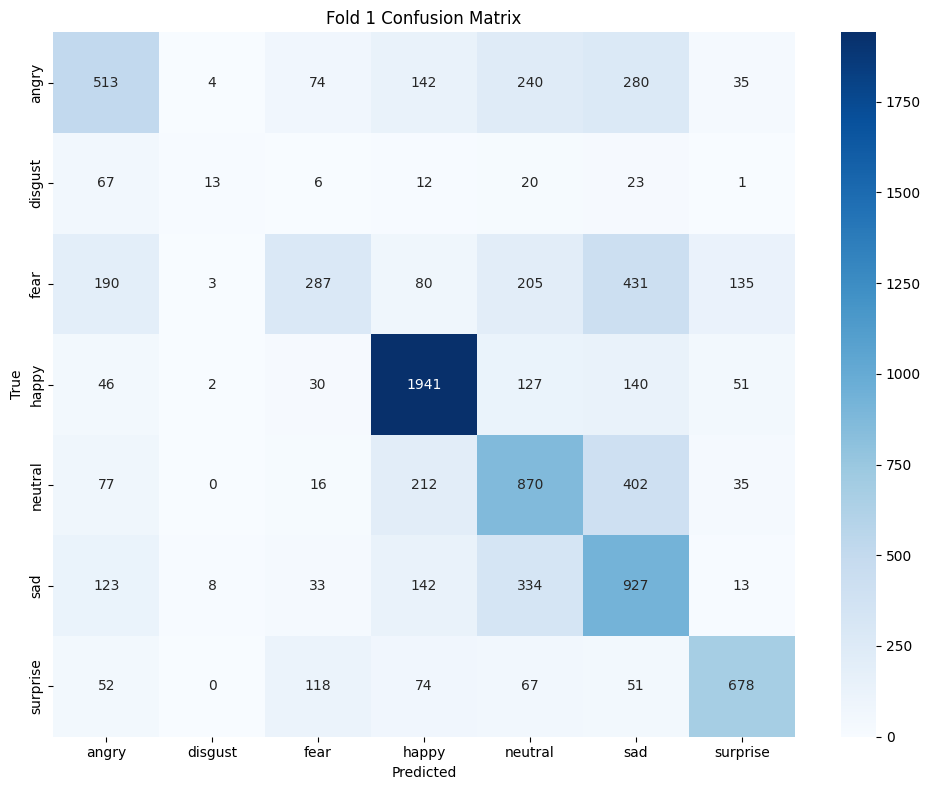

Saved final model for fold 1 to /content/drive/MyDrive/FER465/models/mobilenetv2_fold1_final.pt

FOLD 2/5
Training samples: 37318, Validation samples: 9330
Using pre-trained MobileNetV2
Unfroze the last 3 blocks of MobileNetV2 features
Trainable parameters: 1,865,543 (64.70% of total)

Training epoch 1/20...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20] | Batch [10/584] | Loss: 1.2777 | Acc: 22.03% | Time: 3.59s
Epoch [1/20] | Batch [20/584] | Loss: 1.2715 | Acc: 24.14% | Time: 5.35s
Epoch [1/20] | Batch [30/584] | Loss: 1.2867 | Acc: 24.43% | Time: 7.75s
Epoch [1/20] | Batch [40/584] | Loss: 1.0917 | Acc: 26.13% | Time: 9.83s
Epoch [1/20] | Batch [50/584] | Loss: 1.2037 | Acc: 26.72% | Time: 13.70s
Epoch [1/20] | Batch [60/584] | Loss: 1.1785 | Acc: 28.46% | Time: 15.52s
Epoch [1/20] | Batch [70/584] | Loss: 1.1396 | Acc: 28.97% | Time: 17.91s
Epoch [1/20] | Batch [80/584] | Loss: 1.1261 | Acc: 30.06% | Time: 19.82s
Epoch [1/20] | Batch [90/584] | Loss: 1.0672 | Acc: 30.99% | Time: 22.13s
Epoch [1/20] | Batch [100/584] | Loss: 1.2372 | Acc: 31.09% | Time: 24.48s
Epoch [1/20] | Batch [110/584] | Loss: 1.1030 | Acc: 31.80% | Time: 27.97s
Epoch [1/20] | Batch [120/584] | Loss: 1.0341 | Acc: 32.14% | Time: 29.89s
Epoch [1/20] | Batch [130/584] | Loss: 1.0716 | Acc: 32.49% | Time: 32.25s
Epoch [1/20] | Batch [140/584] | Loss:

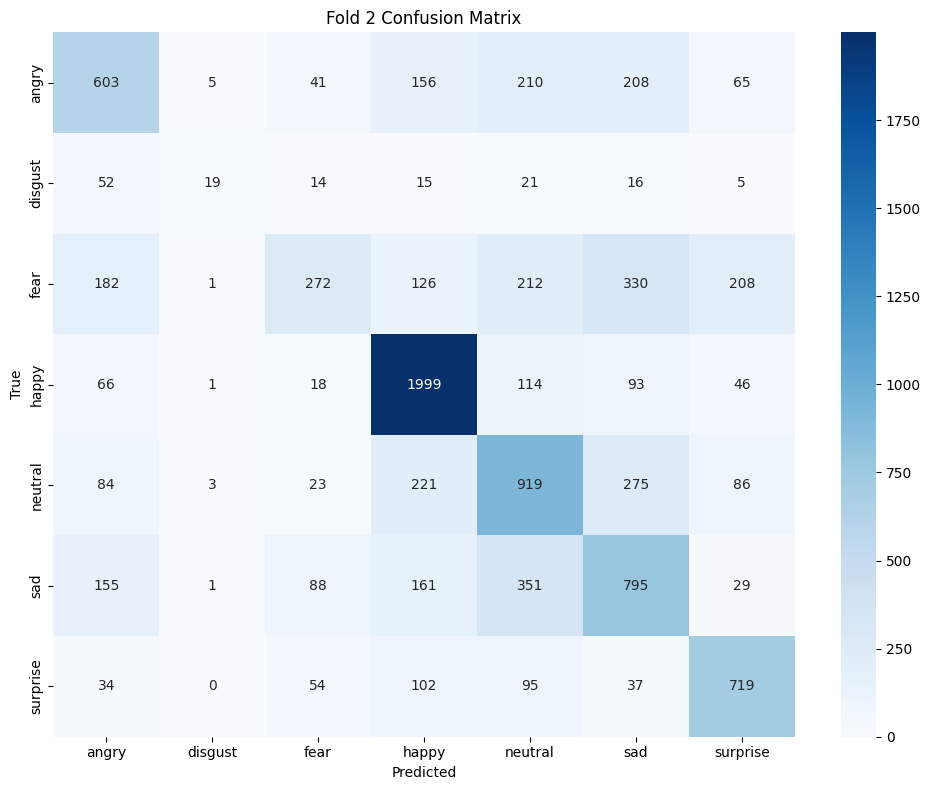

Saved final model for fold 2 to /content/drive/MyDrive/FER465/models/mobilenetv2_fold2_final.pt

FOLD 3/5
Training samples: 37318, Validation samples: 9330
Using pre-trained MobileNetV2
Unfroze the last 3 blocks of MobileNetV2 features
Trainable parameters: 1,865,543 (64.70% of total)

Training epoch 1/20...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20] | Batch [10/584] | Loss: 1.2754 | Acc: 20.31% | Time: 4.10s
Epoch [1/20] | Batch [20/584] | Loss: 1.2159 | Acc: 21.80% | Time: 5.94s
Epoch [1/20] | Batch [30/584] | Loss: 1.2757 | Acc: 23.54% | Time: 8.39s
Epoch [1/20] | Batch [40/584] | Loss: 1.0303 | Acc: 25.55% | Time: 11.13s
Epoch [1/20] | Batch [50/584] | Loss: 1.2109 | Acc: 26.34% | Time: 14.14s
Epoch [1/20] | Batch [60/584] | Loss: 1.3392 | Acc: 27.29% | Time: 16.18s
Epoch [1/20] | Batch [70/584] | Loss: 1.1789 | Acc: 28.19% | Time: 18.36s
Epoch [1/20] | Batch [80/584] | Loss: 1.0902 | Acc: 29.14% | Time: 20.19s
Epoch [1/20] | Batch [90/584] | Loss: 1.1397 | Acc: 30.19% | Time: 22.74s
Epoch [1/20] | Batch [100/584] | Loss: 1.2424 | Acc: 30.67% | Time: 25.46s
Epoch [1/20] | Batch [110/584] | Loss: 1.0656 | Acc: 31.07% | Time: 28.29s
Epoch [1/20] | Batch [120/584] | Loss: 1.1834 | Acc: 31.58% | Time: 30.28s
Epoch [1/20] | Batch [130/584] | Loss: 1.0312 | Acc: 31.86% | Time: 32.53s
Epoch [1/20] | Batch [140/584] | Loss

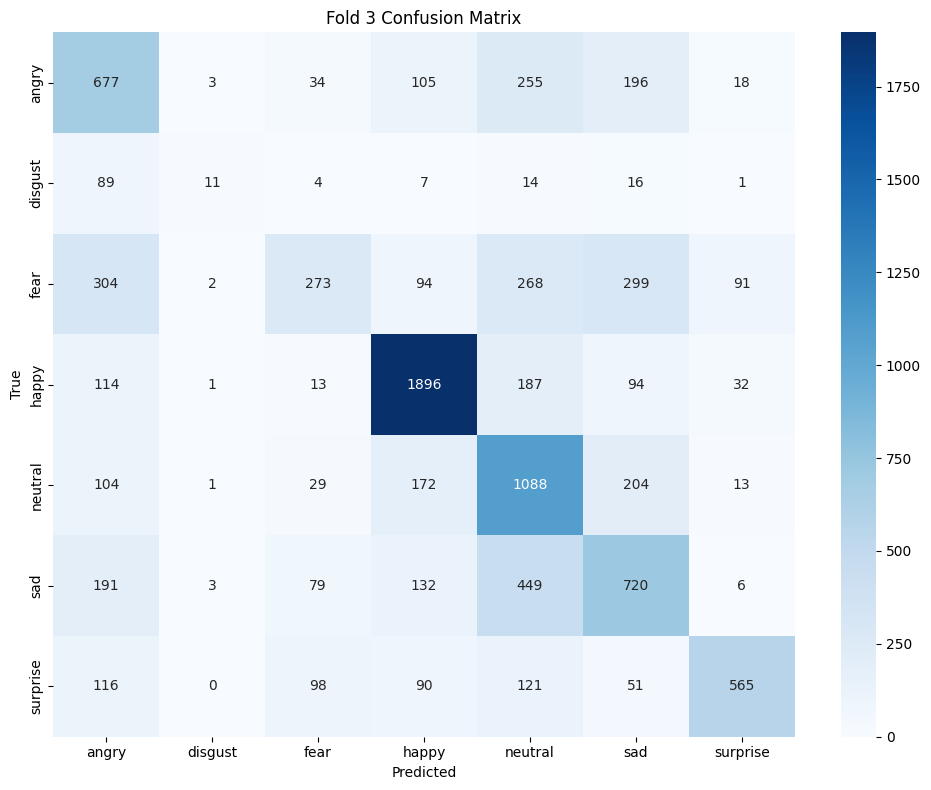

Saved final model for fold 3 to /content/drive/MyDrive/FER465/models/mobilenetv2_fold3_final.pt

FOLD 4/5
Training samples: 37319, Validation samples: 9329
Using pre-trained MobileNetV2
Unfroze the last 3 blocks of MobileNetV2 features
Trainable parameters: 1,865,543 (64.70% of total)

Training epoch 1/20...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20] | Batch [10/584] | Loss: 1.3619 | Acc: 18.91% | Time: 4.26s
Epoch [1/20] | Batch [20/584] | Loss: 1.2780 | Acc: 20.94% | Time: 6.57s
Epoch [1/20] | Batch [30/584] | Loss: 1.1997 | Acc: 21.98% | Time: 9.12s
Epoch [1/20] | Batch [40/584] | Loss: 1.2053 | Acc: 24.02% | Time: 11.03s
Epoch [1/20] | Batch [50/584] | Loss: 1.1993 | Acc: 25.41% | Time: 13.45s
Epoch [1/20] | Batch [60/584] | Loss: 1.1945 | Acc: 26.20% | Time: 15.82s
Epoch [1/20] | Batch [70/584] | Loss: 1.1297 | Acc: 27.75% | Time: 19.63s
Epoch [1/20] | Batch [80/584] | Loss: 1.0390 | Acc: 28.87% | Time: 21.67s
Epoch [1/20] | Batch [90/584] | Loss: 1.1948 | Acc: 29.22% | Time: 24.35s
Epoch [1/20] | Batch [100/584] | Loss: 0.8553 | Acc: 29.83% | Time: 26.17s
Epoch [1/20] | Batch [110/584] | Loss: 0.9365 | Acc: 30.50% | Time: 28.79s
Epoch [1/20] | Batch [120/584] | Loss: 1.0147 | Acc: 31.21% | Time: 31.46s
Epoch [1/20] | Batch [130/584] | Loss: 1.0542 | Acc: 31.83% | Time: 34.61s
Epoch [1/20] | Batch [140/584] | Loss

In [ ]:
print("Loading dataset...")
# Load the dataset (combining train and test for cross-validation)
dataset = FERDataset(DATA_DIR, transform=None)  # No transform here, we'll apply it dynamically
print(f"Dataset loaded with {len(dataset)} samples")
print(f"Classes: {dataset.classes}")

# Get class distribution for balancing
class_counts = [0] * NUM_CLASSES
for _, label in dataset.samples:
    class_counts[label] += 1

total_samples = len(dataset)
print(f"Class distribution:")
for i, count in enumerate(class_counts):
    print(f"  {dataset.classes[i]}: {count} samples ({count/total_samples*100:.2f}%)")

# Create validation indices using stratified sampling to ensure class balance
print("\nPreparing 5-fold cross-validation with stratified sampling...")
skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

# Implement weighted sampling to address class imbalance
class_weights = [total_samples / (NUM_CLASSES * count) for count in class_counts]
sample_weights = [class_weights[label] for _, label in dataset.samples]

fold_results = []

# To store results across folds
all_train_losses = []
all_train_accs = []
all_val_losses = []
all_val_accs = []

for fold, (train_idx, val_idx) in enumerate(skf.split(np.arange(len(dataset)), dataset.targets)):
    print(f"\n{'='*50}")
    print(f"FOLD {fold+1}/{NUM_FOLDS}")
    print(f"{'='*50}")

    # Create separate datasets for training and validation with appropriate transforms
    train_dataset = FERDataset(DATA_DIR, transform=train_transform, subset=None)
    val_dataset = FERDataset(DATA_DIR, transform=val_transform, subset=None)

    # Create samplers for the datasets
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=train_sampler,
        num_workers=4,  # Increase workers for faster data loading
        pin_memory=True  # Speed up data transfer to GPU
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        sampler=val_sampler,
        num_workers=4,
        pin_memory=True
    )

    print(f"Training samples: {len(train_idx)}, Validation samples: {len(val_idx)}")

    # Create a fresh model for this fold with more unfreezed layers
    model = create_model(pretrained=True, unfreeze_layers=3)

    # Count trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.2f}% of total)")

    # Use Focal Loss to handle class imbalance
    criterion = FocalLoss(gamma=2.0)

    # Use AdamW optimizer with weight decay for better regularization
    optimizer = optim.AdamW(
        [
            {'params': [p for n, p in model.named_parameters() if 'classifier' not in n and p.requires_grad], 'lr': LEARNING_RATE/10},
            {'params': model.classifier.parameters(), 'lr': LEARNING_RATE}
        ],
        lr=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY
    )

    # Add learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    # Training loop with enhanced monitoring
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    best_val_acc = 0.0

    for epoch in range(NUM_EPOCHS):
        # Train
        print(f"\nTraining epoch {epoch+1}/{NUM_EPOCHS}...")
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, epoch, NUM_EPOCHS)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Evaluate
        print(f"\nEvaluating epoch {epoch+1}/{NUM_EPOCHS}...")
        val_loss, val_acc, val_preds, val_labels, class_accs = evaluate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Update learning rate based on validation loss
        scheduler.step(val_loss)

        # Print per-class accuracies
        print("\nPer-class accuracies:")
        for i, acc in enumerate(class_accs):
            print(f"  {dataset.classes[i]}: {acc*100:.2f}%")

        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} Summary - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save model if it's the best so far
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            model_path = os.path.join(MODEL_SAVE_DIR, f'mobilenetv2_fold{fold+1}_best.pt')
            torch.save(model.state_dict(), model_path)
            print(f"Saved best model with validation accuracy: {best_val_acc:.4f} to {model_path}")

    # Final evaluation for this fold
    model_path = os.path.join(MODEL_SAVE_DIR, f'mobilenetv2_fold{fold+1}_best.pt')
    model.load_state_dict(torch.load(model_path))  # Load best model
    final_val_loss, final_val_acc, val_preds, val_labels, class_accs = evaluate(model, val_loader, criterion)

    # Calculate classification report and confusion matrix
    class_names = dataset.classes
    report = classification_report(val_labels, val_preds, target_names=class_names)
    conf_matrix = confusion_matrix(val_labels, val_preds)

    print("\nFinal Evaluation using best model:")
    print(f"Validation accuracy: {final_val_acc:.4f}")

    print("\nClassification Report:")
    print(report)

    print("\nConfusion Matrix:")
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Fold {fold+1} Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Store results for this fold
    fold_results.append({
        'fold': fold + 1,
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc,
        'final_val_acc': final_val_acc,
        'conf_matrix': conf_matrix,
        'report': report,
        'class_accs': class_accs
    })

    # Collect for averaging later
    all_train_losses.append(train_losses)
    all_train_accs.append(train_accs)
    all_val_losses.append(val_losses)
    all_val_accs.append(val_accs)

    # Save model for this fold
    final_model_path = os.path.join(MODEL_SAVE_DIR, f'mobilenetv2_fold{fold+1}_final.pt')
    torch.save(model.state_dict(), final_model_path)
    print(f"Saved final model for fold {fold+1} to {final_model_path}")

# Calculate average metrics across folds
avg_train_losses = np.mean(np.array([loss[:min(len(l) for l in all_train_losses)] for loss in all_train_losses]), axis=0)
avg_train_accs = np.mean(np.array([acc[:min(len(a) for a in all_train_accs)] for acc in all_train_accs]), axis=0)
avg_val_losses = np.mean(np.array([loss[:min(len(l) for l in all_val_losses)] for loss in all_val_losses]), axis=0)
avg_val_accs = np.mean(np.array([acc[:min(len(a) for a in all_val_accs)] for acc in all_val_accs]), axis=0)

# Final accuracy across all folds
best_accuracies = [result['best_val_acc'] for result in fold_results]
avg_best_acc = np.mean(best_accuracies)
std_best_acc = np.std(best_accuracies)

final_accuracies = [result['final_val_acc'] for result in fold_results]
avg_final_acc = np.mean(final_accuracies)
std_final_acc = np.std(final_accuracies)

print(f"\n{'='*50}")
print(f"CROSS-VALIDATION RESULTS")
print(f"{'='*50}")
print(f"Average Best Validation Accuracy: {avg_best_acc:.4f} ± {std_best_acc:.4f}")
print(f"Average Final Validation Accuracy: {avg_final_acc:.4f} ± {std_final_acc:.4f}")

# Plot training and validation curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(avg_train_losses)+1), avg_train_losses, 'b-', label='Training Loss')
plt.plot(range(1, len(avg_val_losses)+1), avg_val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss Across Folds')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(avg_train_accs)+1), avg_train_accs, 'b-', label='Training Accuracy')
plt.plot(range(1, len(avg_val_accs)+1), avg_val_accs, 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average Accuracy Across Folds')
plt.legend()

plt.tight_layout()
plt.show()

# Print per-fold results
print("\nPer-Fold Best Validation Accuracies:")
for i, acc in enumerate(best_accuracies):
    print(f"Fold {i+1}: {acc:.4f}")

# Save a comprehensive report
report_path = os.path.join(MODEL_SAVE_DIR, 'mobilenetv2_classification_report.txt')
with open(report_path, 'w') as f:
    f.write("FER Classification with MobileNetV2 - 5-Fold Cross-Validation Report\n")
    f.write("="*50 + "\n\n")
    f.write(f"Average Best Validation Accuracy: {avg_best_acc:.4f} ± {std_best_acc:.4f}\n")
    f.write(f"Average Final Validation Accuracy: {avg_final_acc:.4f} ± {std_final_acc:.4f}\n\n")

    for fold, result in enumerate(fold_results):
        f.write(f"Fold {fold+1} Results:\n")
        f.write(f"Best Validation Accuracy: {result['best_val_acc']:.4f}\n")
        f.write(f"Final Validation Accuracy: {result['final_val_acc']:.4f}\n")
        f.write("\nClassification Report:\n")
        f.write(result['report'] + "\n\n")

        f.write("Per-class accuracies:\n")
        for i, acc in enumerate(result['class_accs']):
            f.write(f"  {dataset.classes[i]}: {acc*100:.2f}%\n")
        f.write("\n" + "="*50 + "\n\n")

print(f"\nTraining completed! A comprehensive report has been saved to '{report_path}'")